In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [21]:
#df = pd.read_csv('../elena/barros_2011_training.csv')
df = pd.read_csv('../data/training_final_latcorr.csv')

## Clean / Reverse Engineer Features
- Electricity generated (kWh)
- Drop redundant columns
- Drop non-lc columns

In [4]:
#df['kWh'] = df['Area_km2'] / df['Area / Electricity']
df = df.drop(['Longitude', 'Latitude','CO2 (g/kWh)', 'CH4 (g/kWh)', 'Area / Electricity', 'Name', 'field_1',
              'temp_spring_avg', 'temp_summer_avg', 'temp_fall_avg', 'temp_winter_avg', 
              'NDVI_spring_avg', 'NDVI_summer_avg', 'NDVI_fall_avg', 'NDVI_winter_avg', 
              'npp_spring_avg' , 'npp_summer_avg' , 'npp_fall_avg' , 'npp_winter_avg'], axis=1)

In [5]:
df.columns

Index(['CO2 (mg C m¯² d¯¹)', 'CH4 (mg C m-2 d-1)', 'Area_km2', 'Age',
       'Volume_km3', 'Areakm2_div_Volkm3', 'org_c', 'temp_annual_avg',
       'temp_diff_summer_winter_lc', 'temp_spring_avg_lc',
       'temp_summer_avg_lc', 'temp_fall_avg_lc', 'temp_winter_avg_lc',
       'NDVI_annual_avg', 'NDVI_spring_avg_lc', 'NDVI_summer_avg_lc',
       'NDVI_fall_avg_lc', 'NDVI_winter_avg_lc', 'npp_annual_avg',
       'npp_spring_avg_lc', 'npp_summer_avg_lc', 'npp_fall_avg_lc',
       'npp_winter_avg_lc', 'erosion', 'precip'],
      dtype='object')

In [6]:
df.shape

(154, 25)

In [ ]:
#create co2 df

In [22]:
co2 = df.drop(['CH4 (mg C m-2 d-1)'], axis=1)
co2 = co2[co2['CO2 (mg C m¯² d¯¹)'].notna()]

In [ ]:
#missingness

In [7]:
# from sklearn.impute import KNNImputer
# model_impute = KNNImputer(n_neighbors=int(np.sqrt(co2.shape[0])))
# co2_imputed = model_impute.fit_transform(co2)

In [8]:
# co2_imputed = pd.DataFrame(columns=co2.columns, data=co2_imputed)

In [9]:
# #check
# for column in co2_imputed:
#     print(column, ':',  co2_imputed[column].isna().sum())

CO2 (mg C m¯² d¯¹) : 0
Area_km2 : 0
Age : 0
Volume_km3 : 0
Areakm2_div_Volkm3 : 0
org_c : 0
temp_annual_avg : 0
temp_spring_avg_lc : 0
temp_summer_avg_lc : 0
temp_fall_avg_lc : 0
temp_winter_avg_lc : 0
NDVI_annual_avg : 0
NDVI_spring_avg_lc : 0
NDVI_summer_avg_lc : 0
NDVI_fall_avg_lc : 0
NDVI_winter_avg_lc : 0
npp_annual_avg : 0
npp_spring_avg_lc : 0
npp_summer_avg_lc : 0
npp_fall_avg_lc : 0
npp_winter_avg_lc : 0
erosion : 0
kWh : 0


### Random Forest

In [11]:
X = co2.drop('CO2 (mg C m¯² d¯¹)', axis=1)
Y = co2['CO2 (mg C m¯² d¯¹)']

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
from sklearn import ensemble

randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(random_state=42, n_estimators=100, max_features=5)
randomForest.fit(x_train, y_train)
randomForest.score(x_train, y_train)

0.9074547464031134

In [14]:
print("The training error is: %.5f" % (1 - randomForest.score(x_train, y_train)))
print("The test     error is: %.5f" % (1 - randomForest.score(x_test, y_test)))

The training error is: 0.09255
The test     error is: 0.67978


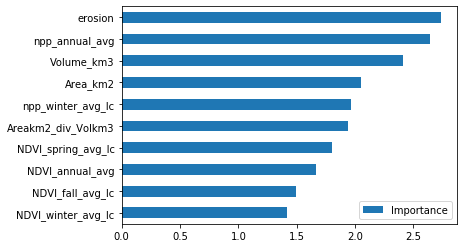

In [19]:
pd.DataFrame(index=x_train.columns, data=randomForest.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=True).head(10).plot(kind='barh')

#list(zip(x_train.columns, randomForest.feature_importances_*100))

#### grid search to find best parameters

In [26]:
from sklearn.model_selection import GridSearchCV

grid_values = {
    "n_estimators": range(200,500,50),
    "max_depth" : range(7,16),
    "max_features" : range(7,16)
}

grid_search_forest = GridSearchCV(randomForest, grid_values, scoring='r2', cv=2, n_jobs=-1)
%time grid_search_forest.fit(x_train, y_train)

CPU times: user 5.43 s, sys: 265 ms, total: 5.69 s
Wall time: 2min 40s


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=8,
                                             max_features=9,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=300, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
   

In [27]:
grid_search_forest.best_params_

{'max_depth': 8, 'max_features': 9, 'n_estimators': 400}

In [28]:
grid_search_forest.best_score_

0.4776556161822082

In [30]:
#using the best parameters, what is the test score?

randomForest.set_params(max_depth =8, max_features = 9, n_estimators = 400)
randomForest.fit(x_train, y_train)
randomForest.score(x_test, y_test)

0.24813583090724592

In [31]:
estimators = pd.DataFrame(grid_search_forest.cv_results_)[['param_n_estimators','mean_test_score']]
depth = pd.DataFrame(grid_search_forest.cv_results_)[['param_max_depth','mean_test_score']]

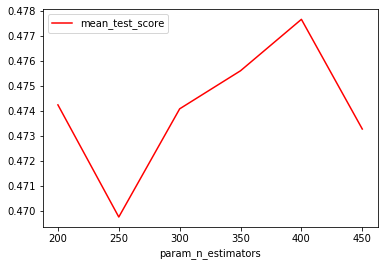

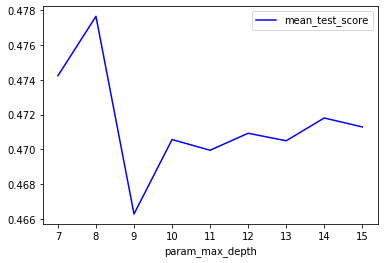

In [32]:
estimators.groupby('param_n_estimators').max().reset_index().plot(kind='line', x='param_n_estimators',y='mean_test_score', c='red')
depth.groupby('param_max_depth').max().reset_index().plot(kind='line', x='param_max_depth', y='mean_test_score', c='blue')


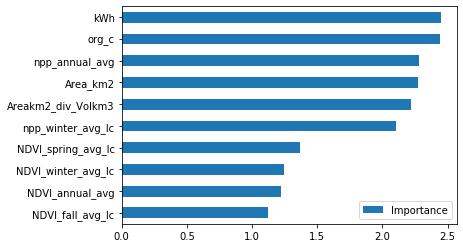

In [33]:
pd.DataFrame(index=x_train.columns, data=randomForest.feature_importances_*100, columns=['Importance']).sort_values(by='Importance', ascending=True).head(10).plot(kind='barh')

In [ ]:
##using less features:

In [51]:
df = pd.read_csv('../data/training_final_latcorr.csv')

In [52]:
co2 = df.drop(['CH4 (mg C m-2 d-1)','Longitude', 'Latitude','CO2 (g/kWh)', 'CH4 (g/kWh)', 'Area / Electricity', 'Name', 'field_1',
              'temp_spring_avg', 'temp_summer_avg', 'temp_fall_avg', 'temp_winter_avg', 
              'NDVI_spring_avg', 'NDVI_summer_avg', 'NDVI_fall_avg', 'NDVI_winter_avg', 
              'npp_spring_avg' , 'npp_summer_avg' , 'npp_fall_avg' , 'npp_winter_avg'], axis=1)
co2['log_co2_emissions'] = np.log(co2['CO2 (mg C m¯² d¯¹)'])
#co2 = co2[co2['CO2 (mg C m¯² d¯¹)'].notna()]

In [57]:
cleaned = co2[['log_co2_emissions','Age', 'org_c', 'temp_annual_avg', 'temp_diff_summer_winter_lc', 
            'NDVI_annual_avg', 'npp_annual_avg', 'erosion', 'precip']].dropna()
cleaned.shape

(120, 9)

In [58]:
features = ['Age', 'org_c', 'temp_annual_avg', 'temp_diff_summer_winter_lc', 
            'NDVI_annual_avg', 'npp_annual_avg', 'erosion', 'precip']

target = 'log_co2_emissions'

In [59]:
X = cleaned[features]
y = cleaned[target]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [60]:
print("X_train.shape =", X_train.shape)
print("X_test.shape  =", X_test.shape)
print("y_train.shape =", y_train.shape)
print("y_test.shape  =", y_test.shape)

X_train.shape = (90, 8)
X_test.shape  = (30, 8)
y_train.shape = (90,)
y_test.shape  = (30,)


In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfr', RandomForestRegressor(random_state=42))
])

pipeline.fit(X_train, y_train)

print("Train score =", pipeline.score(X_train, y_train))
print("Test score  =", pipeline.score(X_test, y_test))

Train score = 0.9051651587651449
Test score  = 0.4559835849712779


In [25]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut, RepeatedKFold, train_test_split

parameters = {
    "rfr__n_estimators" : range(20, 100, 10),
    "rfr__max_depth" : range(1,6),
    "rfr__max_features" : range(1,6)
}

my_cv = RepeatedKFold(n_splits=2, n_repeats=10, random_state=42)

grid_search = GridSearchCV(pipeline, parameters, cv=my_cv, n_jobs=-1, scoring='r2') 

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

grid_search.best_estimator_.score(X_test, y_test)

Best score: 0.066
	rfr__max_depth: 1
	rfr__max_features: 1
	rfr__n_estimators: 60


0.2680015799666259

In [26]:
grid_search.best_estimator_.named_steps['rfr'].feature_importances_

array([0.16666667, 0.11666667, 0.16666667, 0.1       , 0.16666667,
       0.13333333, 0.01666667, 0.13333333])

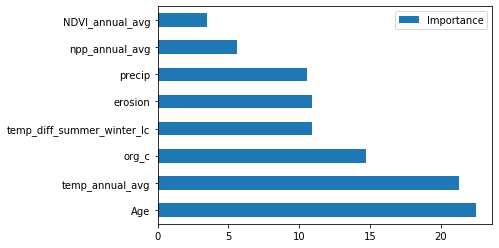

In [62]:
pd.DataFrame(index=X_train.columns,
             data=pipeline.named_steps['rfr'].feature_importances_*100,
             columns=['Importance']).sort_values(by='Importance', ascending=False).plot(kind='barh')

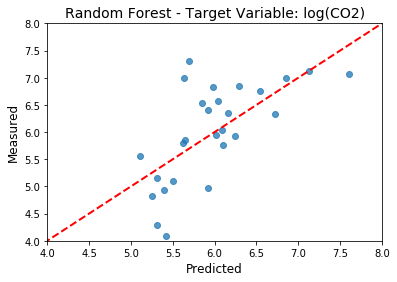

In [136]:
y_pred = pipeline.predict(X_test)
y_true = y_test
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x=y_pred, y=y_true, alpha=.75)
ax.set_title('Random Forest - Target Variable: log(CO2)' , fontsize=14)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Measured', fontsize=12)
ax.set_xlim([4, 8])
ax.set_ylim([4, 8])
ax.plot([0,8], [0, 8], color='red', linestyle='--', linewidth=2)
plt.savefig('rf_pred_vs_mes.png')

In [38]:
y_test.shape

(14,)

In [65]:
present = pd.read_csv('../data_predict/merged_PRESENT.csv')
best_case = pd.read_csv('../data_predict/merged_2100ssp126.csv')
worst_case = pd.read_csv('../data_predict/merged_2100ssp585.csv')

In [66]:
for column in present[features]:
    print(column, ':',  present[features][column].isna().sum())

Age : 0
org_c : 0
temp_annual_avg : 0
temp_diff_summer_winter_lc : 0
NDVI_annual_avg : 0
npp_annual_avg : 33
erosion : 0
precip : 0


In [67]:
present['npp_annual_avg'] = present['npp_annual_avg'].fillna(present['npp_annual_avg'].mean())
best_case['npp_annual_avg'] = best_case['npp_annual_avg'].fillna(best_case['npp_annual_avg'].mean())
worst_case['npp_annual_avg'] = worst_case['npp_annual_avg'].fillna(worst_case['npp_annual_avg'].mean())

In [68]:
present['co2_emissions_logscale'] = pipeline.predict(present[features])
best_case['co2_emissions_logscale'] = pipeline.predict(best_case[features])
worst_case['co2_emissions_logscale'] = pipeline.predict(worst_case[features])

In [69]:
present['co2_emissions'] = 10**present['co2_emissions_logscale']
best_case['co2_emissions'] = 10**best_case['co2_emissions_logscale']
worst_case['co2_emissions'] = 10**worst_case['co2_emissions_logscale']

In [164]:
# present.to_csv('../data_predict/merged_PRESENT_co2predicted_rf.csv')
# best_case.to_csv('../data_predict/merged_2100ssp126_co2predicted_rf.csv')
# worst_case.to_csv('../data_predict/merged_2100ssp585_co2predicted_rf.csv')

In [71]:
present_knn = pd.read_csv('../data_predict/merged_PRESENT_co2predicted.csv')

In [75]:
pd.DataFrame(data = {'KNN':present_knn['co2_emissions'],
                     'RF' :present['co2_emissions']
                    }).describe()

,KNN,RF
count,5.100000e+02,510.000000
mean,3.528688e+05,144181.089214
std,5.851329e+05,176981.151422
min,2.573019e+03,3184.818896
25%,3.892283e+04,20539.294076
50%,1.487217e+05,59033.448077
75%,3.824149e+05,216557.203627
max,4.194479e+06,851433.050359


In [97]:
ch4_feature_importance = pd.read_csv('ch4_feature_importance.csv')

In [98]:
ch4_feature_importance = ch4_feature_importance.set_index([features]).drop('Unnamed: 0', axis=1)

In [99]:
ch4_feature_importance

,ch4_importance
Age,6.921256
org_c,50.923401
temp_annual_avg,7.438457
temp_diff_summer_winter_lc,7.111743
NDVI_annual_avg,4.790956
npp_annual_avg,4.609831
erosion,3.605917
precip,14.598439


In [100]:
co2_feature_importance = pd.DataFrame(index=X_train.columns,
                                     data=pipeline.named_steps['rfr'].feature_importances_*100,
                                     columns=['co2_importance'])

In [93]:
#co2_feature_importance.index = list(map(lambda x: x.lower(), co2_feature_importance.index))

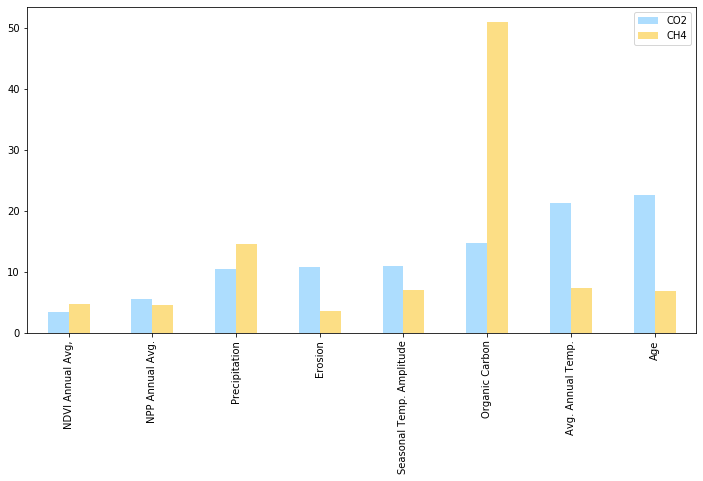

In [152]:
final = co2_feature_importance.join(ch4_feature_importance)
final.columns = ['CO2', 'CH4']
final.index = ['Age', 'Organic Carbon', 'Avg. Annual Temp.', 'Seasonal Temp. Amplitude', 'NDVI Annual Avg,',
              'NPP Annual Avg.', 'Erosion', 'Precipitation']

# plt.figure(figsize=(12,6))
final.sort_values(by='CO2', ascending=True).plot(kind='bar', figsize=(12,6), color=['#ADDDFE', '#FCDE85'])

